In [2]:
import os, argparse
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import timezone
from pathlib import Path
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.backends.cudnn as cudnn
import torchvision
import wandb

import datasets
# from utils import select_device, natural_keys, gazeto3d, angular, getArch
from utils import select_device, natural_keys, gazeto3d, angular, getArch
from model import L2CS

In [4]:

args = argparse.Namespace()
args.gazeMpiimage_dir = '/project/data/Image'  #real data 
args.gazeMpiilabel_dir = '/project/data/Label'  #real label
# args.output = '/project/results/soutput1/snapshots/'
args.dataset = 'mpiigaze'
args.snapshot='/project/results/soutput1/snapshots/'
# args.evalpath = '/project/results/sroutput1/evaluation/'
args.gpu_id = '0,1,2,3'
args.gpu_id = '0'
args.batch_size = 20
args.arch = 'ResNet50'
args.bins=35
args.angle = 180
args.bin_width = 4


In [5]:
batch_size=args.batch_size
arch=args.arch
data_set=args.dataset
# evalpath =args.evalpath
snapshot_path = args.snapshot
bins=args.bins
angle=args.angle
bin_width=args.bin_width

In [4]:
# args = parse_args()
cudnn.enabled = True
gpu = select_device(args.gpu_id, batch_size=args.batch_size)
transformations = transforms.Compose([
    transforms.Resize(448),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

model_used=getArch(arch, bins)  #resnet50 and 28 bins

In [5]:
# check if we have the correct number of checkpoint files 
ppath = snapshot_path
for fold in range(15):
    foldstr = f"fold{fold:0>2}"
    cpath =os.path.join(ppath, foldstr)
    files = os.listdir(cpath)
    print(f'{fold}:{len(files)}',end=" ")

0:60 1:60 2:60 3:60 4:60 5:60 6:60 7:60 8:60 9:60 10:60 11:60 12:60 13:60 14:60 

In [6]:
def get_now():
    now = datetime.utcnow()
    now = now.astimezone(timezone('US/Pacific'))
    date_format='%m/%d/%Y %H:%M:%S'
    now = now.strftime(date_format) 
    return now
print(get_now())

06/27/2022 12:26:38


In [7]:
%%time
all_MAE = []
# tosave={}
for fold in range(15):
    frun = wandb.init(project="51_syn_mode_real_data")
    frun.name = f'fold{fold}_mae'
    
    print(f"fold={fold}")
    
    epoch_values=[]
    mae_values=[]

    now = get_now()
    
    print(args.gazeMpiilabel_dir)
    folder = os.listdir(args.gazeMpiilabel_dir)
    folder.sort()  #individual label files
    testlabelpathcombined = [os.path.join(args.gazeMpiilabel_dir, j) for j in folder] 
    
    gaze_dataset=datasets.Mpiigaze(testlabelpathcombined, args.gazeMpiimage_dir, transformations, False, angle, fold)

    test_loader = torch.utils.data.DataLoader(
        dataset=gaze_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True)

#     fold_path = os.path.join(evalpath, 'fold' + f'{fold:0>2}'+'/')  #for evaluation
#     print(f"fold_path is {fold_path}")
#     if not os.path.exists(fold_path):
#         os.makedirs(fold_path)

#     if not os.path.exists(os.path.join(evalpath, f"fold"+str(fold))):
#         os.makedirs(os.path.join(evalpath, f"fold"+str(fold)))

    # list all epoch for testing
    folder = os.listdir(os.path.join(snapshot_path, "fold" + f'{fold:0>2}'))
    folder.sort(key=natural_keys)
#     folder.pop(-1)  #remove the tensorboard file, now all snapshot files
#     print(f"folder={folder}")
                    

    softmax = nn.Softmax(dim=1)
#     with open(os.path.join(evalpath, os.path.join("fold"+f'{fold:0>2}', data_set+".log")), 'w') as outfile:
        
    configuration = (f"\ntest configuration equal gpu_id={gpu}, batch_size={batch_size}, model_arch={arch}\n"
                     f"Start testing dataset={data_set}, FOLD={fold} --{now}---------")
    print(configuration)
#     tosave['time':now]
#     outfile.write(configuration)
    epoch_list=[]
    avg_MAE=[]
    for epoch in folder: 
        print(f"entering epoch={epoch}")
        model=model_used
        checkpoint = torch.load(os.path.join(snapshot_path+"fold"+f'{fold:0>2}', epoch))
        saved_state_dict = checkpoint['model_state_dict']
        model= nn.DataParallel(model,device_ids=[0])
        model.load_state_dict(saved_state_dict)
        model.cuda(gpu)
        model.eval()
        total = 0
        idx_tensor = [idx for idx in range(35)]
        idx_tensor = torch.FloatTensor(idx_tensor).cuda(gpu)
        avg_error = .0
        with torch.no_grad():
            for j, (images, labels, cont_labels, name) in enumerate(test_loader):
                images = Variable(images).cuda(gpu)
                total += cont_labels.size(0)

                label_pitch = cont_labels[:,0].float()*np.pi/180
                label_yaw = cont_labels[:,1].float()*np.pi/180

                gaze_pitch, gaze_yaw = model(images)

                # Binned predictions
                _, pitch_bpred = torch.max(gaze_pitch.data, 1)
                _, yaw_bpred = torch.max(gaze_yaw.data, 1)

                # Continuous predictions
                pitch_predicted = softmax(gaze_pitch)
                yaw_predicted = softmax(gaze_yaw)

                # mapping from binned (0 to 28) to angels (-42 to 42)                
                pitch_predicted = \
                    torch.sum(pitch_predicted * idx_tensor, 1).cpu() * 3 - 52
                yaw_predicted = \
                    torch.sum(yaw_predicted * idx_tensor, 1).cpu() * 3 - 52

                pitch_predicted = pitch_predicted*np.pi/180
                yaw_predicted = yaw_predicted*np.pi/180

                for p,y,pl,yl in zip(pitch_predicted, yaw_predicted, label_pitch, label_yaw):
                    pl, yl = yl, pl*(-1.0)
#                     yl = yl*(-1.0)
                    avg_error += angular(gazeto3d([p,y]), gazeto3d([pl,yl]))

        x = ''.join(filter(lambda i: i.isdigit(), epoch))
#             print(f"x={x}")
        
        epoch_list.append(x)
        mean_mae = avg_error/total  #mean mae over the 3000 iamges
        avg_MAE.append(mean_mae)  
#             print(f"total={total}")
        now = get_now()
        loger = f"[{epoch}---{args.dataset}] Total Num:{total},MAE:{mean_mae}  {now}"
#         outfile.write(loger)
        print(loger)
#             print(f"done epoch={epochs}")
        epochn = int(x)
#         wandb.log({'epoch':epochn,'total':total, 'MAE':mean_mae, 'FOLD':fold })
#         tosave ={'epoch':epochn,'total':total, 'MAE':mean_mae, 'FOLD':fold }
        epoch_values.append(epochn)
        mae_values.append(mean_mae)
# #         wandb.log(tosave)
        wandb.log({'epoch': epoch, f'try3_fold_{fold}_avg_mae':mean_mae}, step=epochn)
       
    all_MAE.append(avg_MAE)
    wandb.finish()


wandb: Currently logged in as: synthesis-ai (use `wandb login --relogin` to force relogin)


fold=0
/project/data/Label
0 items removed from dataset that have an angle > 180

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=0 --06/27/2022 12:26:41---------
entering epoch=epoch_1.pkl
[epoch_1.pkl---mpiigaze] Total Num:3000,MAE:7.48677585295966  06/27/2022 12:26:56
entering epoch=epoch_2.pkl
[epoch_2.pkl---mpiigaze] Total Num:3000,MAE:9.01417653100146  06/27/2022 12:27:04
entering epoch=epoch_3.pkl
[epoch_3.pkl---mpiigaze] Total Num:3000,MAE:4.611029225717101  06/27/2022 12:27:12
entering epoch=epoch_4.pkl
[epoch_4.pkl---mpiigaze] Total Num:3000,MAE:5.048243855628022  06/27/2022 12:27:19
entering epoch=epoch_5.pkl
[epoch_5.pkl---mpiigaze] Total Num:3000,MAE:5.277268154003953  06/27/2022 12:27:27
entering epoch=epoch_6.pkl
[epoch_6.pkl---mpiigaze] Total Num:3000,MAE:5.2285667087484375  06/27/2022 12:27:34
entering epoch=epoch_7.pkl
[epoch_7.pkl---mpiigaze] Total Num:3000,MAE:4.658634825454906  06/27/2022 12:27:42
ente

try3_fold_0_avg_mae,▆█▂▃▂▂▂▁▂▂▂▃▁▁▁▂▂▁▁▂▂▂▁▂▂▂▁▂▁▂▁▂▂▂▃▂▁▂▁▁
epoch,epoch_60.pkl
try3_fold_0_avg_mae,4.43955


fold=1
/project/data/Label
0 items removed from dataset that have an angle > 180

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=1 --06/27/2022 12:34:29---------
entering epoch=epoch_1.pkl
[epoch_1.pkl---mpiigaze] Total Num:3000,MAE:6.218286463813767  06/27/2022 12:34:42
entering epoch=epoch_2.pkl
[epoch_2.pkl---mpiigaze] Total Num:3000,MAE:6.420130805923361  06/27/2022 12:34:49
entering epoch=epoch_3.pkl
[epoch_3.pkl---mpiigaze] Total Num:3000,MAE:7.752906422197179  06/27/2022 12:34:57
entering epoch=epoch_4.pkl
[epoch_4.pkl---mpiigaze] Total Num:3000,MAE:6.8762145584445005  06/27/2022 12:35:04
entering epoch=epoch_5.pkl
[epoch_5.pkl---mpiigaze] Total Num:3000,MAE:6.482267909632053  06/27/2022 12:35:12
entering epoch=epoch_6.pkl
[epoch_6.pkl---mpiigaze] Total Num:3000,MAE:7.416907124473344  06/27/2022 12:35:19
entering epoch=epoch_7.pkl
[epoch_7.pkl---mpiigaze] Total Num:3000,MAE:6.358976427730542  06/27/2022 12:35:27
en

try3_fold_1_avg_mae,▂▃▅▃▃▃▆▅▂▂▄▂▃▃▂▁█▆▄▂▁▂▅▅▃▂▁▂▅▄▄▂▄▃▅▅▄▁▄▁
epoch,epoch_60.pkl
try3_fold_1_avg_mae,5.94064


fold=2
/project/data/Label
0 items removed from dataset that have an angle > 180

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=2 --06/27/2022 12:44:45---------
entering epoch=epoch_1.pkl
[epoch_1.pkl---mpiigaze] Total Num:3000,MAE:7.123808537266993  06/27/2022 12:44:59
entering epoch=epoch_2.pkl
[epoch_2.pkl---mpiigaze] Total Num:3000,MAE:8.133352139678516  06/27/2022 12:45:10
entering epoch=epoch_3.pkl
[epoch_3.pkl---mpiigaze] Total Num:3000,MAE:6.782486845880018  06/27/2022 12:45:21
entering epoch=epoch_4.pkl
[epoch_4.pkl---mpiigaze] Total Num:3000,MAE:7.058589029773891  06/27/2022 12:45:32
entering epoch=epoch_5.pkl
[epoch_5.pkl---mpiigaze] Total Num:3000,MAE:6.559141130467233  06/27/2022 12:45:44
entering epoch=epoch_6.pkl
[epoch_6.pkl---mpiigaze] Total Num:3000,MAE:6.358813145935694  06/27/2022 12:45:56
entering epoch=epoch_7.pkl
[epoch_7.pkl---mpiigaze] Total Num:3000,MAE:6.607669037308785  06/27/2022 12:46:08
ent

try3_fold_2_avg_mae,▅█▅▄▄▃▃▃▂▂▃▂▃▁▂▂▅▁▃▂▂▃▂▁▂▂▂▂▂▂▂▃▁▂▂▁▁▁▂▂
epoch,epoch_60.pkl
try3_fold_2_avg_mae,5.74797


fold=3
/project/data/Label
0 items removed from dataset that have an angle > 180

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=3 --06/27/2022 12:56:43---------
entering epoch=epoch_1.pkl
[epoch_1.pkl---mpiigaze] Total Num:3000,MAE:10.932875769396427  06/27/2022 12:56:56
entering epoch=epoch_2.pkl
[epoch_2.pkl---mpiigaze] Total Num:3000,MAE:7.558270001227589  06/27/2022 12:57:08
entering epoch=epoch_3.pkl
[epoch_3.pkl---mpiigaze] Total Num:3000,MAE:7.126807541029014  06/27/2022 12:57:20
entering epoch=epoch_4.pkl
[epoch_4.pkl---mpiigaze] Total Num:3000,MAE:7.029244685827183  06/27/2022 12:57:32
entering epoch=epoch_5.pkl
[epoch_5.pkl---mpiigaze] Total Num:3000,MAE:6.473367229591572  06/27/2022 12:57:43
entering epoch=epoch_6.pkl
[epoch_6.pkl---mpiigaze] Total Num:3000,MAE:6.891454403120648  06/27/2022 12:57:56
entering epoch=epoch_7.pkl
[epoch_7.pkl---mpiigaze] Total Num:3000,MAE:8.526642712675157  06/27/2022 12:58:08
en

try3_fold_3_avg_mae,█▃▂▁▄▃▄▂▃▄▂▃▃▄▃▃▃▂▄▃▄▄▃▂▅▃▄▂▅▃▂▃▄▄▅▅▄▄▃▅
epoch,epoch_60.pkl
try3_fold_3_avg_mae,8.95584


fold=4
/project/data/Label
0 items removed from dataset that have an angle > 180

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=4 --06/27/2022 13:08:47---------
entering epoch=epoch_1.pkl
[epoch_1.pkl---mpiigaze] Total Num:3000,MAE:9.28691466719907  06/27/2022 13:09:00
entering epoch=epoch_2.pkl
[epoch_2.pkl---mpiigaze] Total Num:3000,MAE:7.095215624736195  06/27/2022 13:09:13
entering epoch=epoch_3.pkl
[epoch_3.pkl---mpiigaze] Total Num:3000,MAE:8.9458225025351  06/27/2022 13:09:25
entering epoch=epoch_4.pkl
[epoch_4.pkl---mpiigaze] Total Num:3000,MAE:7.07116485441141  06/27/2022 13:09:37
entering epoch=epoch_5.pkl
[epoch_5.pkl---mpiigaze] Total Num:3000,MAE:6.89937823903171  06/27/2022 13:09:49
entering epoch=epoch_6.pkl
[epoch_6.pkl---mpiigaze] Total Num:3000,MAE:7.402740484983406  06/27/2022 13:10:01
entering epoch=epoch_7.pkl
[epoch_7.pkl---mpiigaze] Total Num:3000,MAE:6.46159718903304  06/27/2022 13:10:12
entering 

try3_fold_4_avg_mae,█▄▄▃▃▃▃▃▂▃▅▂▃▃▃▂▃▄▃▁▃▂▁▁▁▂▂▂▁▂▄▃▄▃▂▃▁▂▂▄
epoch,epoch_60.pkl
try3_fold_4_avg_mae,6.95421


fold=5
/project/data/Label
0 items removed from dataset that have an angle > 180

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=5 --06/27/2022 13:20:59---------
entering epoch=epoch_1.pkl
[epoch_1.pkl---mpiigaze] Total Num:3000,MAE:7.306100499084364  06/27/2022 13:21:11
entering epoch=epoch_2.pkl
[epoch_2.pkl---mpiigaze] Total Num:3000,MAE:6.577576291791338  06/27/2022 13:21:24
entering epoch=epoch_3.pkl
[epoch_3.pkl---mpiigaze] Total Num:3000,MAE:7.0537427335699165  06/27/2022 13:21:36
entering epoch=epoch_4.pkl
[epoch_4.pkl---mpiigaze] Total Num:3000,MAE:6.783310371701471  06/27/2022 13:21:44
entering epoch=epoch_5.pkl
[epoch_5.pkl---mpiigaze] Total Num:3000,MAE:6.996469248062855  06/27/2022 13:21:56
entering epoch=epoch_6.pkl
[epoch_6.pkl---mpiigaze] Total Num:3000,MAE:6.435533227190469  06/27/2022 13:22:08
entering epoch=epoch_7.pkl
[epoch_7.pkl---mpiigaze] Total Num:3000,MAE:6.345420447943866  06/27/2022 13:22:21
en

try3_fold_5_avg_mae,█▄▅▆▃▂▃▇▄▂▃▁▂▂▁▂▂▂▁▂▂▂▁▂▁▂▁▁▂▁▁▂▂▂▂▁▂▂▃▂
epoch,epoch_60.pkl
try3_fold_5_avg_mae,6.23627


fold=6
/project/data/Label
0 items removed from dataset that have an angle > 180

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=6 --06/27/2022 13:32:57---------
entering epoch=epoch_1.pkl
[epoch_1.pkl---mpiigaze] Total Num:3000,MAE:16.931525131216585  06/27/2022 13:33:10
entering epoch=epoch_2.pkl
[epoch_2.pkl---mpiigaze] Total Num:3000,MAE:14.093322463074392  06/27/2022 13:33:21
entering epoch=epoch_3.pkl
[epoch_3.pkl---mpiigaze] Total Num:3000,MAE:12.654723089565001  06/27/2022 13:33:32
entering epoch=epoch_4.pkl
[epoch_4.pkl---mpiigaze] Total Num:3000,MAE:14.808130642897323  06/27/2022 13:33:44
entering epoch=epoch_5.pkl
[epoch_5.pkl---mpiigaze] Total Num:3000,MAE:12.116863361348193  06/27/2022 13:33:57
entering epoch=epoch_6.pkl
[epoch_6.pkl---mpiigaze] Total Num:3000,MAE:14.546073642353909  06/27/2022 13:34:09
entering epoch=epoch_7.pkl
[epoch_7.pkl---mpiigaze] Total Num:3000,MAE:13.219066488821444  06/27/2022 13:34

try3_fold_6_avg_mae,█▆▆▄▅▄▅▃▃▂▃▃▃▂▃▂▂▂▃▂▂▂▃▂▂▂▂▂▂▂▁▂▂▂▃▂▂▁▂▁
epoch,epoch_60.pkl
try3_fold_6_avg_mae,9.49653


fold=7
/project/data/Label
0 items removed from dataset that have an angle > 180

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=7 --06/27/2022 13:44:58---------
entering epoch=epoch_1.pkl
[epoch_1.pkl---mpiigaze] Total Num:3000,MAE:9.593829867132087  06/27/2022 13:45:11
entering epoch=epoch_2.pkl
[epoch_2.pkl---mpiigaze] Total Num:3000,MAE:8.387292524574304  06/27/2022 13:45:23
entering epoch=epoch_3.pkl
[epoch_3.pkl---mpiigaze] Total Num:3000,MAE:8.492829061126368  06/27/2022 13:45:35
entering epoch=epoch_4.pkl
[epoch_4.pkl---mpiigaze] Total Num:3000,MAE:8.506850705583  06/27/2022 13:45:47
entering epoch=epoch_5.pkl
[epoch_5.pkl---mpiigaze] Total Num:3000,MAE:8.070663747986263  06/27/2022 13:45:59
entering epoch=epoch_6.pkl
[epoch_6.pkl---mpiigaze] Total Num:3000,MAE:7.952482161610704  06/27/2022 13:46:11
entering epoch=epoch_7.pkl
[epoch_7.pkl---mpiigaze] Total Num:3000,MAE:9.10097384422238  06/27/2022 13:46:23
enterin

try3_fold_7_avg_mae,█▅▆▅▇█▆▄▃▅▅▅▂▂▂▃▃▂▂▂▃▂▃▂▂▂▂▂▂▁▃▁▂▁▂▂▂▁▁▁
epoch,epoch_60.pkl
try3_fold_7_avg_mae,6.65916


fold=8
/project/data/Label
0 items removed from dataset that have an angle > 180

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=8 --06/27/2022 13:57:03---------
entering epoch=epoch_1.pkl
[epoch_1.pkl---mpiigaze] Total Num:3000,MAE:8.890846748062236  06/27/2022 13:57:16
entering epoch=epoch_2.pkl
[epoch_2.pkl---mpiigaze] Total Num:3000,MAE:8.768986624776009  06/27/2022 13:57:28
entering epoch=epoch_3.pkl
[epoch_3.pkl---mpiigaze] Total Num:3000,MAE:8.809893267826205  06/27/2022 13:57:40
entering epoch=epoch_4.pkl
[epoch_4.pkl---mpiigaze] Total Num:3000,MAE:8.879650652724417  06/27/2022 13:57:51
entering epoch=epoch_5.pkl
[epoch_5.pkl---mpiigaze] Total Num:3000,MAE:8.54548985344194  06/27/2022 13:58:03
entering epoch=epoch_6.pkl
[epoch_6.pkl---mpiigaze] Total Num:3000,MAE:8.914795461966706  06/27/2022 13:58:15
entering epoch=epoch_7.pkl
[epoch_7.pkl---mpiigaze] Total Num:3000,MAE:9.509551246382367  06/27/2022 13:58:27
ente

try3_fold_8_avg_mae,▆▆▆▅█▇▅▄▆▃▅▄▄▃▃▃▂▃▃▃▂▂▄▂▂▆▂▂▂▃▂▂▁▁▁▂▁▁▁▁
epoch,epoch_60.pkl
try3_fold_8_avg_mae,6.98025


fold=9
/project/data/Label
0 items removed from dataset that have an angle > 180

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=9 --06/27/2022 14:09:02---------
entering epoch=epoch_1.pkl
[epoch_1.pkl---mpiigaze] Total Num:3000,MAE:11.224235849617374  06/27/2022 14:09:15
entering epoch=epoch_2.pkl
[epoch_2.pkl---mpiigaze] Total Num:3000,MAE:9.134612334447382  06/27/2022 14:09:26
entering epoch=epoch_3.pkl
[epoch_3.pkl---mpiigaze] Total Num:3000,MAE:8.22377010413491  06/27/2022 14:09:38
entering epoch=epoch_4.pkl
[epoch_4.pkl---mpiigaze] Total Num:3000,MAE:8.83010286809993  06/27/2022 14:09:51
entering epoch=epoch_5.pkl
[epoch_5.pkl---mpiigaze] Total Num:3000,MAE:8.38605041121338  06/27/2022 14:10:03
entering epoch=epoch_6.pkl
[epoch_6.pkl---mpiigaze] Total Num:3000,MAE:8.75582788655706  06/27/2022 14:10:15
entering epoch=epoch_7.pkl
[epoch_7.pkl---mpiigaze] Total Num:3000,MAE:9.3991781937329  06/27/2022 14:10:26
entering

try3_fold_9_avg_mae,█▄▄▃▅▄▄█▄▅▅▅▃▅▆▅▄▃▃▂▂▁▂▁▁▃▂▃▃▂▄▃▂▂▃▂▃▄▄▄
epoch,epoch_60.pkl
try3_fold_9_avg_mae,8.92614


fold=10
/project/data/Label
0 items removed from dataset that have an angle > 180

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=10 --06/27/2022 14:21:05---------
entering epoch=epoch_1.pkl
[epoch_1.pkl---mpiigaze] Total Num:3000,MAE:9.694782112640732  06/27/2022 14:21:18
entering epoch=epoch_2.pkl
[epoch_2.pkl---mpiigaze] Total Num:3000,MAE:8.514581490315305  06/27/2022 14:21:31
entering epoch=epoch_3.pkl
[epoch_3.pkl---mpiigaze] Total Num:3000,MAE:12.19171749985733  06/27/2022 14:21:43
entering epoch=epoch_4.pkl
[epoch_4.pkl---mpiigaze] Total Num:3000,MAE:8.850339877714372  06/27/2022 14:21:55
entering epoch=epoch_5.pkl
[epoch_5.pkl---mpiigaze] Total Num:3000,MAE:10.288874923075078  06/27/2022 14:22:08
entering epoch=epoch_6.pkl
[epoch_6.pkl---mpiigaze] Total Num:3000,MAE:9.224114408722379  06/27/2022 14:22:20
entering epoch=epoch_7.pkl
[epoch_7.pkl---mpiigaze] Total Num:3000,MAE:9.3440713950444  06/27/2022 14:22:32
en

try3_fold_10_avg_mae,▃▁▂▄▂▃▇▃▆▆▅▃▆▃▃▄█▅▄▇▅▅▄▅▄▄▄▄▆▆▅▅▄▄▃▅▄▅▆▄
epoch,epoch_60.pkl
try3_fold_10_avg_mae,10.42817


fold=11
/project/data/Label
0 items removed from dataset that have an angle > 180

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=11 --06/27/2022 14:33:17---------
entering epoch=epoch_1.pkl
[epoch_1.pkl---mpiigaze] Total Num:3000,MAE:9.085629588176639  06/27/2022 14:33:30
entering epoch=epoch_2.pkl
[epoch_2.pkl---mpiigaze] Total Num:3000,MAE:9.491888561832779  06/27/2022 14:33:43
entering epoch=epoch_3.pkl
[epoch_3.pkl---mpiigaze] Total Num:3000,MAE:7.613727255646428  06/27/2022 14:33:55
entering epoch=epoch_4.pkl
[epoch_4.pkl---mpiigaze] Total Num:3000,MAE:10.015695941532158  06/27/2022 14:34:07
entering epoch=epoch_5.pkl
[epoch_5.pkl---mpiigaze] Total Num:3000,MAE:7.2713786697791924  06/27/2022 14:34:18
entering epoch=epoch_6.pkl
[epoch_6.pkl---mpiigaze] Total Num:3000,MAE:7.719452710768059  06/27/2022 14:34:30
entering epoch=epoch_7.pkl
[epoch_7.pkl---mpiigaze] Total Num:3000,MAE:7.190656998081645  06/27/2022 14:34:43

try3_fold_11_avg_mae,▆▇█▂▂▃▃▃▅▃▂▃▃▆▂▄▃▄▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▃▁▁▂▃
epoch,epoch_60.pkl
try3_fold_11_avg_mae,7.77275


fold=12
/project/data/Label
0 items removed from dataset that have an angle > 180

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=12 --06/27/2022 14:45:27---------
entering epoch=epoch_1.pkl
[epoch_1.pkl---mpiigaze] Total Num:3000,MAE:9.516085817727737  06/27/2022 14:45:40
entering epoch=epoch_2.pkl
[epoch_2.pkl---mpiigaze] Total Num:3000,MAE:10.724681489063544  06/27/2022 14:45:52
entering epoch=epoch_3.pkl
[epoch_3.pkl---mpiigaze] Total Num:3000,MAE:9.201789634489925  06/27/2022 14:46:03
entering epoch=epoch_4.pkl
[epoch_4.pkl---mpiigaze] Total Num:3000,MAE:9.516923945681675  06/27/2022 14:46:13
entering epoch=epoch_5.pkl
[epoch_5.pkl---mpiigaze] Total Num:3000,MAE:8.666925798164295  06/27/2022 14:46:23
entering epoch=epoch_6.pkl
[epoch_6.pkl---mpiigaze] Total Num:3000,MAE:8.214443733110649  06/27/2022 14:46:35
entering epoch=epoch_7.pkl
[epoch_7.pkl---mpiigaze] Total Num:3000,MAE:7.656914937655178  06/27/2022 14:46:47


try3_fold_12_avg_mae,▆█▆▄▂▄▂▆▅▃▄▃▄▃▃▂▂▄▂▃▂▂▃▂▃▄▃▂▅▄▂▂▂▄▁▂▃▂▁▂
epoch,epoch_60.pkl
try3_fold_12_avg_mae,7.76687


fold=13
/project/data/Label
0 items removed from dataset that have an angle > 180

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=13 --06/27/2022 14:57:45---------
entering epoch=epoch_1.pkl
[epoch_1.pkl---mpiigaze] Total Num:3000,MAE:8.07164256025546  06/27/2022 14:57:58
entering epoch=epoch_2.pkl
[epoch_2.pkl---mpiigaze] Total Num:3000,MAE:8.916440622928182  06/27/2022 14:58:10
entering epoch=epoch_3.pkl
[epoch_3.pkl---mpiigaze] Total Num:3000,MAE:7.548629153856305  06/27/2022 14:58:22
entering epoch=epoch_4.pkl
[epoch_4.pkl---mpiigaze] Total Num:3000,MAE:7.921603043123802  06/27/2022 14:58:35
entering epoch=epoch_5.pkl
[epoch_5.pkl---mpiigaze] Total Num:3000,MAE:7.474929644201843  06/27/2022 14:58:49
entering epoch=epoch_6.pkl
[epoch_6.pkl---mpiigaze] Total Num:3000,MAE:7.412712013108675  06/27/2022 14:59:01
entering epoch=epoch_7.pkl
[epoch_7.pkl---mpiigaze] Total Num:3000,MAE:6.62257939367753  06/27/2022 14:59:15
ent

try3_fold_13_avg_mae,▅█▅▄▁▅▃▅▂▅▃▆▃▄▃▄▆▅▄▅▅▄▃▅▆█▄▄▄█▆▄▇▄▄▆▅▇▆▇
epoch,epoch_60.pkl
try3_fold_13_avg_mae,8.50645


fold=14
/project/data/Label
0 items removed from dataset that have an angle > 180

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=14 --06/27/2022 15:10:41---------
entering epoch=epoch_1.pkl
[epoch_1.pkl---mpiigaze] Total Num:3000,MAE:9.573038108450055  06/27/2022 15:10:54
entering epoch=epoch_2.pkl
[epoch_2.pkl---mpiigaze] Total Num:3000,MAE:11.98600276028902  06/27/2022 15:11:07
entering epoch=epoch_3.pkl
[epoch_3.pkl---mpiigaze] Total Num:3000,MAE:10.97540079195821  06/27/2022 15:11:19
entering epoch=epoch_4.pkl
[epoch_4.pkl---mpiigaze] Total Num:3000,MAE:10.453847541069797  06/27/2022 15:11:32
entering epoch=epoch_5.pkl
[epoch_5.pkl---mpiigaze] Total Num:3000,MAE:8.87306798405972  06/27/2022 15:11:45
entering epoch=epoch_6.pkl
[epoch_6.pkl---mpiigaze] Total Num:3000,MAE:9.81026537972797  06/27/2022 15:11:58
entering epoch=epoch_7.pkl
[epoch_7.pkl---mpiigaze] Total Num:3000,MAE:9.504498143404234  06/27/2022 15:12:11
en

try3_fold_14_avg_mae,▅█▆▄▅▅▄▅▃▃▂▁▄▂▃▃▄▁▃▂▂▁▁▂▂▃▂▂▂▂▄▃▂▂▂▂▂▂▃▃
epoch,epoch_60.pkl
try3_fold_14_avg_mae,7.28667


CPU times: user 2h 50min 44s, sys: 21min 46s, total: 3h 12min 31s
Wall time: 2h 56min 58s


In [8]:
all_MAE=np.array(all_MAE)

In [6]:
save_file = Path(snapshot_path).parent/"all_MAE.npy"

In [10]:
with open(save_file, 'wb') as f:
    np.save(f, all_MAE)

In [11]:

print(all_MAE.shape)
print(all_MAE.mean(axis=0))
print(all_MAE.mean(axis=1))
print(all_MAE.mean(axis=0).argmin()+1 ,all_MAE.mean(axis=0).min())

(15, 60)
[9.3957585  8.98776868 8.53235168 8.50999417 7.89214242 8.15227883
 8.03376209 8.06915903 7.63007331 8.2019409  8.08020162 7.78318193
 7.83476043 7.8168375  7.96919987 7.82936575 7.68852823 7.8608107
 7.67840561 7.57252635 7.58342264 7.5715159  7.49181993 7.5322482
 7.97471473 7.50702839 7.67136904 7.56152917 7.46948226 7.46211908
 7.39060439 7.32388153 7.2386315  7.37255232 7.26857423 7.46167483
 7.37338248 7.51982735 7.6398238  7.28205503 7.18300088 7.20701827
 7.50341573 7.54836921 7.27364037 7.50750178 7.39335302 7.18739933
 7.39655064 7.40429373 7.54000949 7.40005583 7.50630661 7.42796113
 7.34882317 7.22433685 7.31092217 7.41462253 7.49038525 7.47316476]
[ 4.79202495  6.47641447  6.0299531   7.90100698  6.54459702  6.2748614
 10.90614332  7.43677399  7.6887817   8.80412051 10.8005085   7.49378621
  8.13757408  7.86425131  7.58831126]
41 7.183000883806455


In [12]:
best_epoch = all_MAE.mean(axis=0).argmin()+1
min_error = all_MAE.mean(axis=0).min()
mean_errors = all_MAE.mean(axis=0)
print(best_epoch,min_error, mean_errors.shape )

41 7.183000883806455 (60,)


In [13]:
xx = mean_errors
min_error = 100
with wandb.init(project="51_syn_mode_real_data") as run:
    run.name = "mean_error_per_epoch"
    for epoch in range(len(xx)):
        err = xx[epoch]
        if err < min_error:
            min_error = err
            run.summary["minimum_error (degree)"] = min_error
        run.log({f'mean epoch error (degree)':err}, step=epoch)
        

mean epoch error (degree),█▇▅▃▄▄▄▄▃▃▃▃▃▂▂▂▄▂▂▂▂▁▂▁▂▂▁▁▂▂▂▂▂▂▂▂▂▁▂▂
mean epoch error (degree),7.47316
minimum_error (degree),7.183


In [41]:


best_epoch = {}
best_epoch_error = {}
print(f"fold   best_epoch error(degree)")
for idx, fdata in enumerate(all_MAE):
    epoch_min_error = np.argmin(fdata)+1
    print(f'{idx:^4} {np.argmin(fdata)+1:^12} {fdata.min():^11.3f}')
    best_epoch[idx+1] = epoch_min_error
    best_epoch_error[idx+1]=fdata.min()


fold   best_epoch error(degree)
 0        28         4.164   
 1        15         5.675   
 2        20         5.499   
 3        12         5.931   
 4        59         5.573   
 5        36         5.969   
 6        56         8.927   
 7        56         6.521   
 8        57         6.756   
 9        35         7.391   
 10       2          8.515   
 11       56         6.589   
 12       58         7.173   
 13       7          6.623   
 14       26         5.989   


In [7]:
all_MAE = np.load(save_file)

In [9]:
all_MAE.shape

(15, 60)

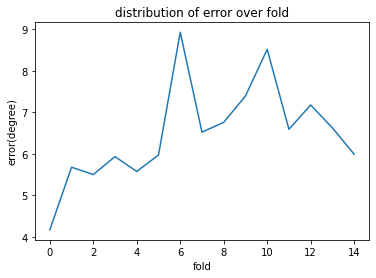

In [37]:
plt.plot(all_MAE.min(axis=1))
plt.title('distribution of error over fold')
plt.xlabel('fold')
plt.ylabel('error(degree)')
with wandb.init(project="51_syn_mode_real_data") as run:
    run.log({'data':wandb.Image(plt)})